# Persiapaan Awal

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [3]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [4]:
df = pd.read_csv('sentiment_5400.csv')
df.head(10)

,content,sentimen
0,kabel menjuntai jalan bisma utara papanggo tan...,negatif
1,capres nomor urut 1 anies baswedan merespons t...,negatif
2,kepala staf tni angkatan darat ksad jenderal d...,negatif
3,khoiri 52 warga dusun blimbing desa parerejo k...,negatif
4,mantan ketua mahkamah konstitusi mk jimly assh...,negatif
5,relawan prabowo gibran bernama muarah 49 tokoh...,negatif
6,ketua umum psi kaesang pangarep menantang mant...,negatif
7,produsen barang konsumen acapkali ditemui bara...,negatif
8,nasib tragis dialami dosen universitas hasanud...,negatif
9,mahasiswa bernama rizki agus saputra mengaku d...,negatif


In [5]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [6]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [7]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [8]:
# Bag of Words (BoW) features
count_vectorizer, count_train_features = tfidf_extractor(x_train, ngram_range=(1, 1))  # Unigram features
count_test_features = count_vectorizer.transform(x_test)

In [9]:
# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

### World Cloud

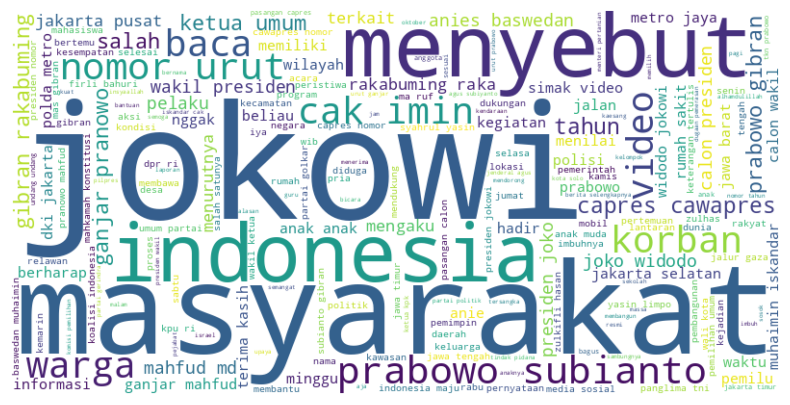

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### LSA

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Membuat vektor TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['content'])

# Membuat model LSA dengan 10 topik
lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Menampilkan kata-kata teratas untuk setiap topik
terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lsa_model.components_):
    top_terms = [terms[j] for j in topic.argsort()[-5:]]
    print(f"Topik {i+1}: {', '.join(top_terms)}")


Topik 1: cawapres, presiden, ganjar, gibran, prabowo
Topik 2: syahrul, bahuri, syl, firli, kpk
Topik 3: serangan, palestina, hamas, gaza, israel
Topik 4: pranowo, anies, kpu, mahfud, ganjar
Topik 5: pdip, tni, mahfud, ganjar, jokowi
Topik 6: cak, imin, korban, anies, tni
Topik 7: mkmk, putusan, mahkamah, konstitusi, mk
Topik 8: mahfud, anak, gibran, pelaku, korban
Topik 9: jenderal, panglima, agus, kpu, tni
Topik 10: presiden, capres, debat, jokowi, kpu


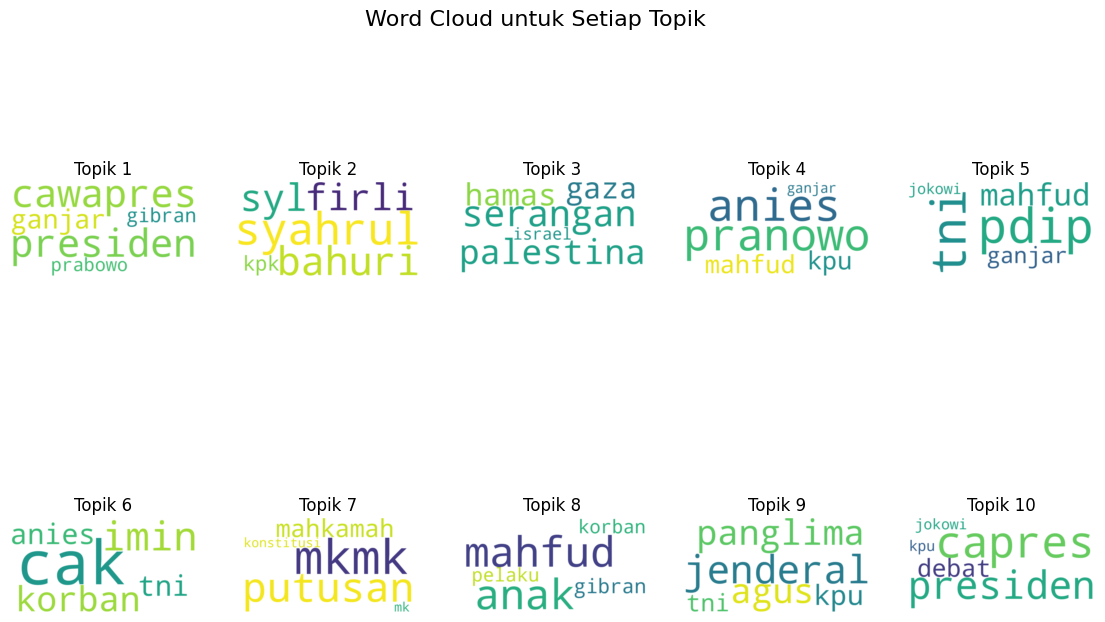

In [12]:
# Membuat model LSA dengan 10 topik
lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Mendapatkan kata-kata teratas untuk setiap topik
terms = vectorizer.get_feature_names_out()
top_terms_per_topic = []
for topic in lsa_model.components_:
    top_terms = [terms[j] for j in topic.argsort()[-5:]]
    top_terms_per_topic.append(top_terms)

# Word Cloud
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_terms_per_topic[i]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topik {i+1}')
    plt.axis('off')
plt.suptitle('Word Cloud untuk Setiap Topik', fontsize=16)
plt.show()

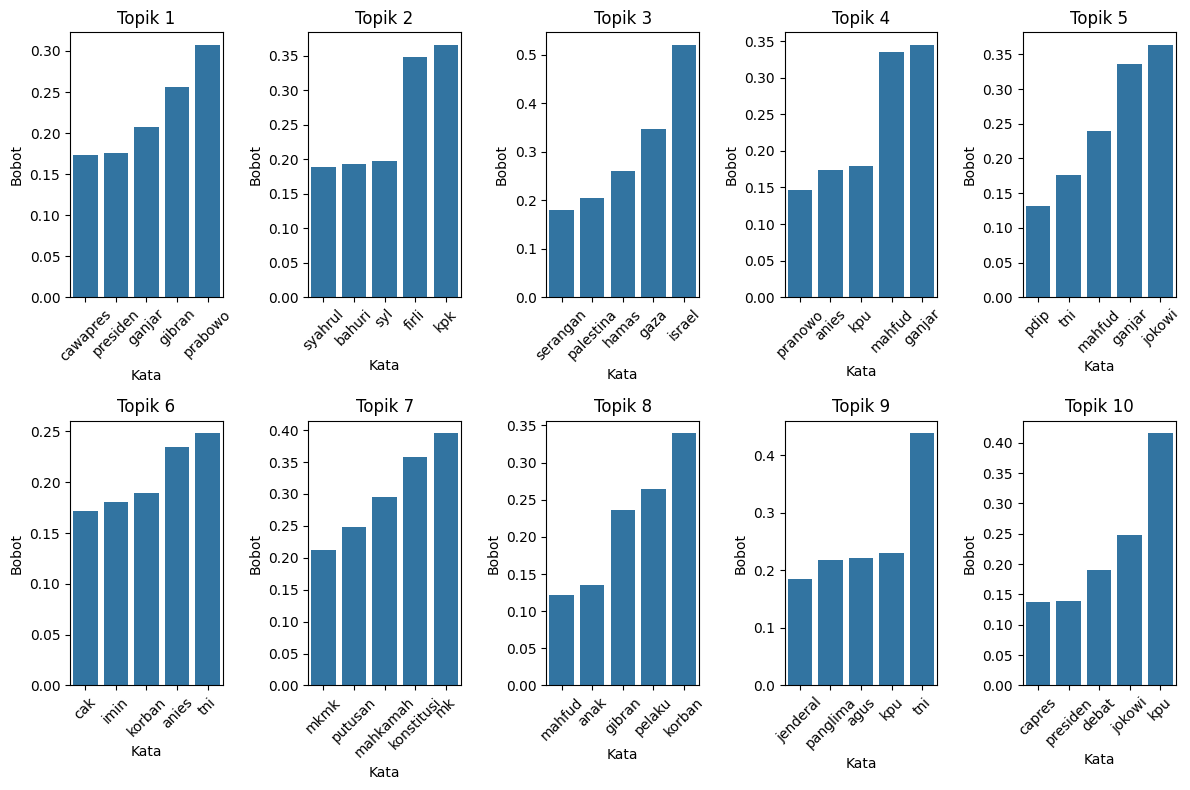

In [13]:
import seaborn as sns
# Bar Plot Topik Kata untuk LSA
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    top_terms = [terms[j] for j in lsa_model.components_[i].argsort()[-5:]]
    top_weights = sorted(lsa_model.components_[i])[-5:]
    sns.barplot(x=top_terms, y=top_weights)
    plt.title(f'Topik {i+1}')
    plt.xlabel('Kata')
    plt.ylabel('Bobot')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model Naiye Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [15]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    return accuracy, f1

#### Tanpa Parameter

In [16]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 80.00%
TF-IDF Vectorization F1 Score: 79.85%
Bag of Words (BoW) Accuracy: 81.42%
Bag of Words (BoW) F1 Score: 81.27%
Combined TF-IDF and BoW Accuracy: 80.31%
Combined TF-IDF and BoW F1 Score: 80.16%


#### Pakai Parameter

In [17]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha= 0.1,fit_prior=True)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 83.27%
TF-IDF Vectorization F1 Score: 83.20%
Bag of Words (BoW) Accuracy: 83.27%
Bag of Words (BoW) F1 Score: 83.19%
Combined TF-IDF and BoW Accuracy: 83.33%
Combined TF-IDF and BoW F1 Score: 83.25%


## Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Parameter Sederhana

In [19]:
# Initialize SVM
model_svm_tanpa_parameter =  SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 90.31%
TF-IDF Vectorization F1 Score: 90.27%
Bag of Words (BoW) Accuracy: 90.31%
Bag of Words (BoW) F1 Score: 90.29%
Combined TF-IDF and BoW Accuracy: 90.99%
Combined TF-IDF and BoW F1 Score: 90.98%


#### Pakai Parameter

In [20]:
# Initialize SVM
model_svm_parameter =  SVC(C=100, gamma=0.1, kernel='linear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 90.43%
TF-IDF Vectorization F1 Score: 90.41%
Bag of Words (BoW) Accuracy: 90.56%
Bag of Words (BoW) F1 Score: 90.55%
Combined TF-IDF and BoW Accuracy: 90.86%
Combined TF-IDF and BoW F1 Score: 90.85%


## Model Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Parameter

In [22]:
# Initialize Naive Bayes classifier
model_lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 86.36%
TF-IDF Vectorization F1 Score: 86.29%
Bag of Words (BoW) Accuracy: 87.90%
Bag of Words (BoW) F1 Score: 87.87%
Combined TF-IDF and BoW Accuracy: 88.58%
Combined TF-IDF and BoW F1 Score: 88.55%


#### Parameter

In [23]:
# Initialize Naive Bayes classifier
model_lr_parameter = LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='liblinear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 88.52%
TF-IDF Vectorization F1 Score: 88.51%
Bag of Words (BoW) Accuracy: 88.64%
Bag of Words (BoW) F1 Score: 88.63%
Combined TF-IDF and BoW Accuracy: 88.70%
Combined TF-IDF and BoW F1 Score: 88.69%


## Model Random Forest 

In [24]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Parameter

In [25]:
# Initialize SVM
model_rfc_tanpa_parameter =  RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 84.63%
TF-IDF Vectorization F1 Score: 84.20%
Bag of Words (BoW) Accuracy: 86.67%
Bag of Words (BoW) F1 Score: 86.40%
Combined TF-IDF and BoW Accuracy: 85.68%
Combined TF-IDF and BoW F1 Score: 85.36%


#### Parameter

In [26]:
# Initialize SVM
model_rfc_parameter =  RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,n_estimators=200,random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy: {:.2f}%".format(tfidf_accuracy * 100))
print("TF-IDF Vectorization F1 Score: {:.2f}%".format(tfidf_f1 * 100))
print("Bag of Words (BoW) Accuracy: {:.2f}%".format(bow_accuracy * 100))
print("Bag of Words (BoW) F1 Score: {:.2f}%".format(bow_f1 * 100))
print("Combined TF-IDF and BoW Accuracy: {:.2f}%".format(combined_accuracy * 100))
print("Combined TF-IDF and BoW F1 Score: {:.2f}%".format(combined_f1 * 100))

TF-IDF Vectorization Accuracy: 84.88%
TF-IDF Vectorization F1 Score: 84.53%
Bag of Words (BoW) Accuracy: 85.56%
Bag of Words (BoW) F1 Score: 85.23%
Combined TF-IDF and BoW Accuracy: 84.38%
Combined TF-IDF and BoW F1 Score: 83.99%


## Model Ensemble Learning

In [27]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = model_svm_parameter
best_model_random_forest = model_rfc_parameter
best_model_logistic_regression = model_lr_parameter

In [28]:
from sklearn.ensemble import VotingClassifier

#### 4 Model

In [29]:
# # Membuat model ensemble
# ensemble_model = VotingClassifier(estimators=[
#     ('naive_bayes', best_model_naive_bayes),
#     ('svm', best_model_svm),
#     ('random_forest', best_model_random_forest),
#     ('logistic_regression', best_model_logistic_regression)
# ], voting='hard')

In [30]:
# # Train and evaluate on TF-IDF Vectorization
# tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# # Train and evaluate on Bag of Words (BoW) features
# bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# # Train and evaluate on Combined TF-IDF and BoW features
# combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# # Print results
# print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
# print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
# print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
# print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
# print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
# print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

#### 3 Model

In [31]:
# ensemble_model_3 = VotingClassifier(estimators=[
#     ('svm', best_model_svm),
#     ('random_forest', best_model_random_forest),
#     ('logistic_regression', best_model_logistic_regression)
# ], voting='hard')

In [32]:
# # Train and evaluate on TF-IDF Vectorization
# tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model_3 , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# # Train and evaluate on Bag of Words (BoW) features
# bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model_3 , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# # Train and evaluate on Combined TF-IDF and BoW features
# combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model_3 , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# # Print results
# print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
# print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
# print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
# print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
# print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
# print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

#### 2 Model

In [33]:
# ensemble_model_2 = VotingClassifier(estimators=[
#     ('svm', best_model_svm),
#     ('logistic_regression', best_model_logistic_regression)
# ], voting='hard')

In [34]:
# # Train and evaluate on TF-IDF Vectorization
# tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model_2 , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# # Train and evaluate on Bag of Words (BoW) features
# bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model_2, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# # Train and evaluate on Combined TF-IDF and BoW features
# combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model_2, combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# # Print results
# print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
# print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
# print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
# print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
# print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
# print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)